In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,classification_report

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.models import Sequential , Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from PIL import ImageFilter,ImageEnhance

In [2]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
df = pd.read_csv("../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

# Creating New Columns for better readability

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


### See the distribution of cell_type

<Axes: >

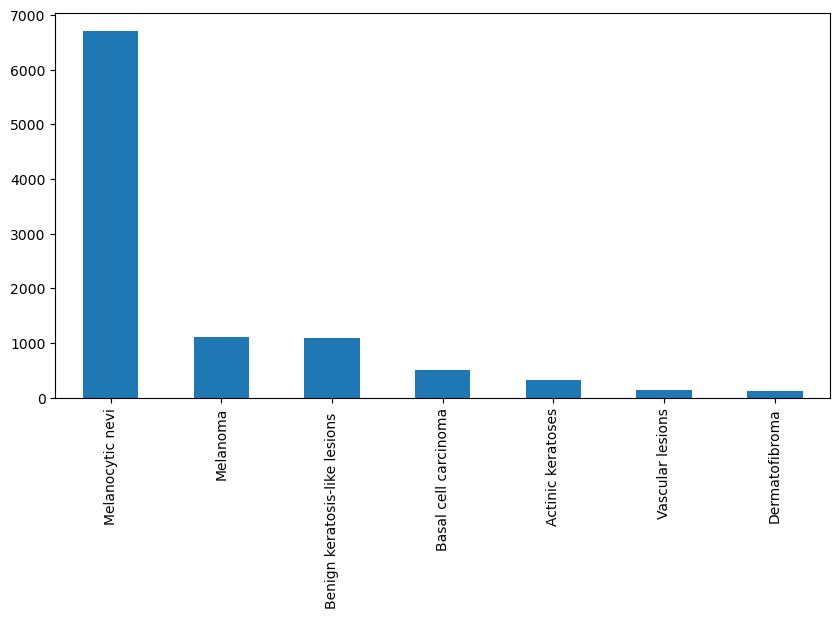

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

This is useful when certain errors occur during detection where we can see that the train data is not all in balance

### Resize the image into 150x100

this takes quite a long time...

In [6]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((150,100))))

### See the sample images of cell type

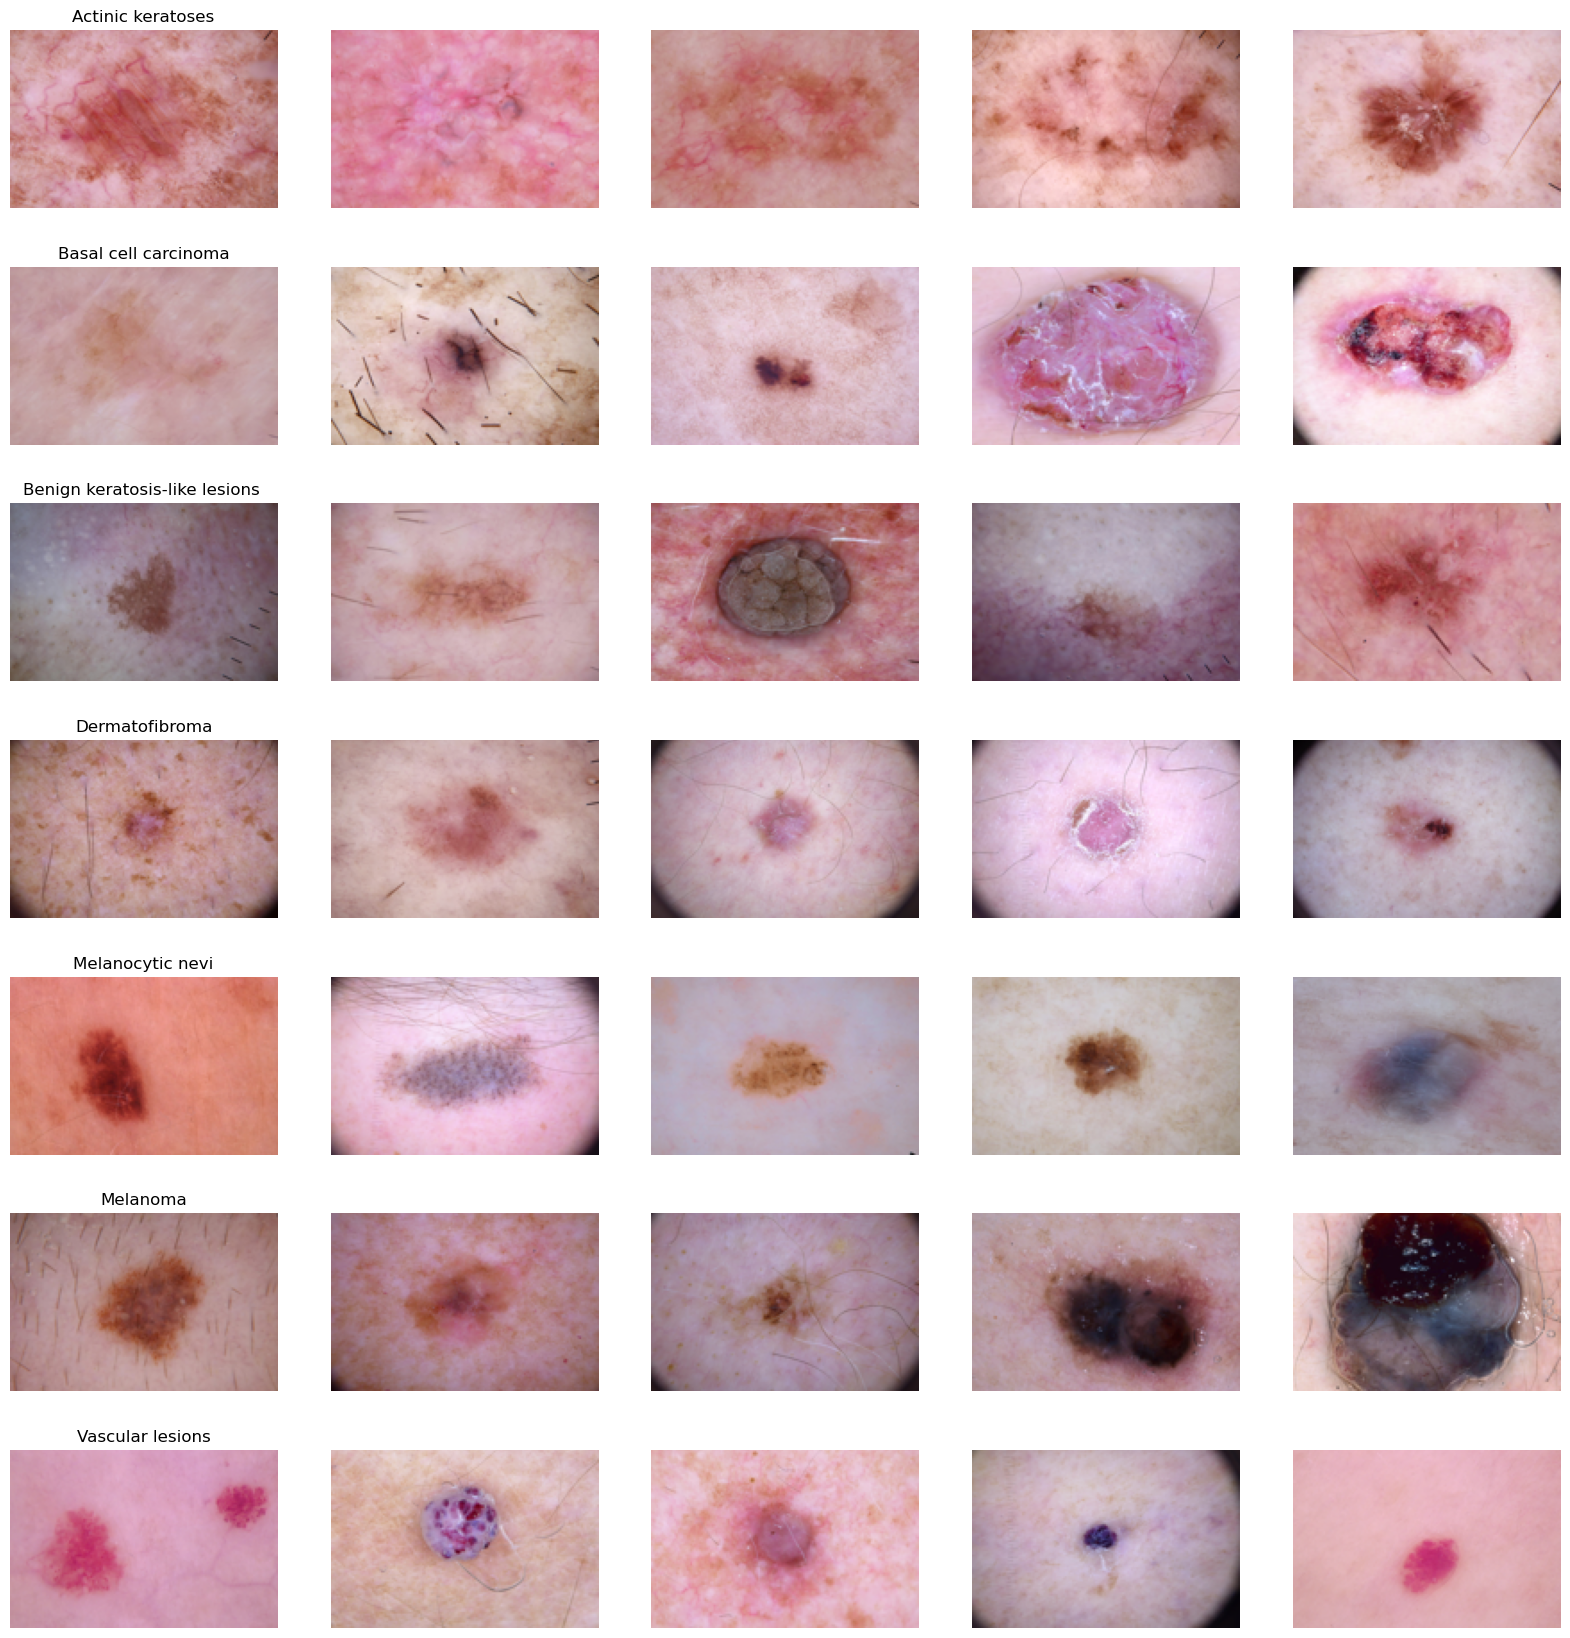

In [7]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

## Dataset Splitting

In [9]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [10]:
x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(features, target, test_size=0.20)

In [12]:
x_train = np.asarray(x_train_0['image'].tolist())
x_test = np.asarray(x_test_0['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

We took a normalization approach for train and test data. The purpose of normalization is to scale the data to a more standardized range, making it easier for the model to process.

In [13]:
rgb_info_df = df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)

In [15]:
for col in rgb_info_df.columns:
    rgb_info_df[col] = rgb_info_df[col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df

,Red_mean,Green_mean,Blue_mean,Gray_mean
0,0.006141,0.004787,0.005344,184.367778
1,0.006295,0.004999,0.005658,176.967156
2,0.006497,0.004747,0.005283,181.514156
3,0.007174,0.005228,0.005762,165.171244
4,0.005970,0.004737,0.005224,188.319978
...,...,...,...,...
10010,0.006151,0.005129,0.005221,181.813756
10011,0.006852,0.005727,0.005774,163.461667
10012,0.005490,0.004737,0.004761,200.158978
10013,0.006572,0.005365,0.005751,169.601933


In [17]:
for col in rgb_info_df.columns:
    df[col] = rgb_info_df[col].values 

In [18]:
y_train = to_categorical(y_train_0, num_classes = 7)
y_test = to_categorical(y_test_0, num_classes = 7)

In [19]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

In [20]:
x_train = x_train.reshape(x_train.shape[0], *(100, 150, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 150, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 150, 3))

In [21]:
input_shape = (100, 150, 3)
num_classes = 7

## Model Building

In [24]:
from keras.applications import InceptionV3, ResNet50, VGG19, MobileNet

In [26]:
base = MobileNet(weights="imagenet", include_top=False , input_shape=(100, 150, 3))

In [28]:
from keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization

x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

## Model Architecture

In [29]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 5.3 MB/s eta 0:00:0000:0100:01


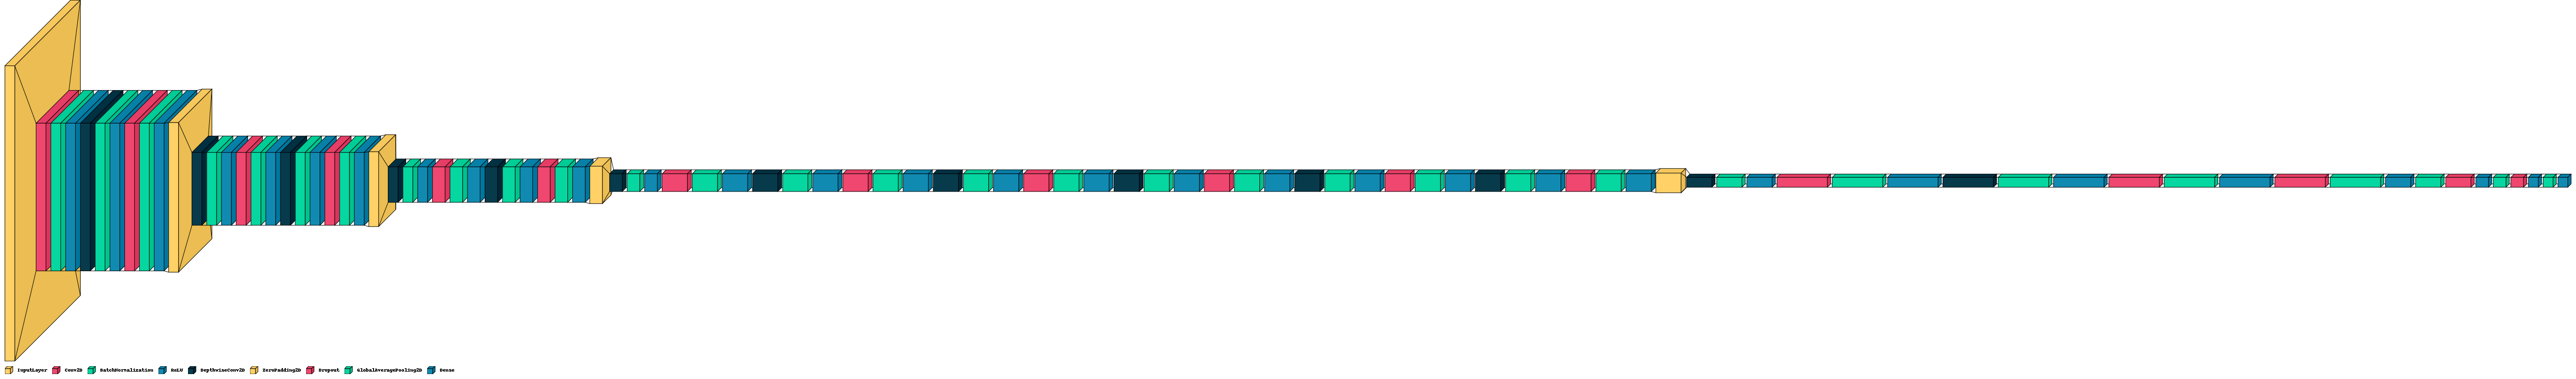

In [30]:
import visualkeras
visualkeras.layered_view(model, legend=True) 

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 75, 32)       128       
 ation)                                                      

In [32]:
from keras.optimizers import Nadam

In [35]:
optim = Nadam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=None, schedule_decay=0.004)

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [40]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Data Augmentation

In [38]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( 
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True,
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False)  

datagen.fit(x_train)

In [41]:
epochs = 30
batch_size = 32

history = model.fit(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[lr_reduction]
)

Epoch 1/30
225/225 [==============================] - 29s 127ms/step - loss: 0.8000 - accuracy: 0.7363 - val_loss: 1.0096 - val_accuracy: 0.6908 - lr: 0.0010
Epoch 2/30
225/225 [==============================] - 28s 125ms/step - loss: 0.7010 - accuracy: 0.7586 - val_loss: 1.1027 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 3/30
225/225 [==============================] - 29s 128ms/step - loss: 0.6806 - accuracy: 0.7575 - val_loss: 0.8190 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 4/30
225/225 [==============================] - 29s 128ms/step - loss: 0.6546 - accuracy: 0.7678 - val_loss: 0.8080 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 5/30
225/225 [==============================] - 28s 126ms/step - loss: 0.6403 - accuracy: 0.7725 - val_loss: 0.8020 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 6/30
225/225 [==============================] - 28s 126ms/step - loss: 0.6251 - accuracy: 0.7739 - val_loss: 0.7475 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 7/30
225/225 [==============================] 

## Model Evaluation

In [42]:
def plot_model_history(model_history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    plt.plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    plt.plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='best')

    plt.tight_layout()
    plt.show()

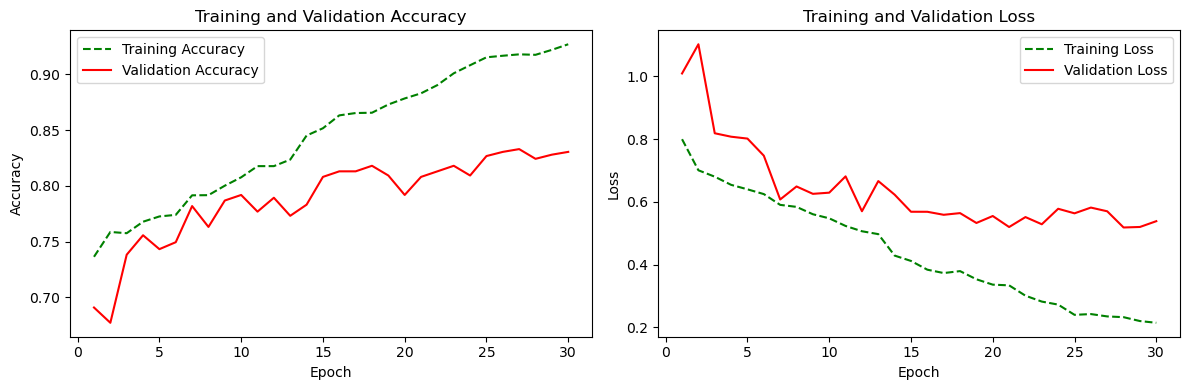

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'g--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'g--', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

26/26 [==============================] - 1s 19ms/step - loss: 0.5387 - accuracy: 0.8304
Validation: accuracy = 0.830424  ;  loss_v = 0.538724
Test: accuracy = 0.848727  ;  loss = 0.499319


In [47]:
labels = ['Actinic Keratoses', 'Basal Cell Carcinoma', 'Benign Keratosis', 'Dermatofibroma', 'Malignant Melanoma', 'Melanocytic Nevi', 'Vascular Lesions']

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
print(classification_report(Y_true, Y_pred_classes, target_names=labels))

63/63 [==============================] - 1s 12ms/step
                      precision    recall  f1-score   support

   Actinic Keratoses       0.61      0.48      0.54        64
Basal Cell Carcinoma       0.74      0.71      0.72       100
    Benign Keratosis       0.76      0.73      0.75       225
      Dermatofibroma       0.65      0.62      0.64        24
  Malignant Melanoma       0.90      0.96      0.93      1320
    Melanocytic Nevi       0.72      0.50      0.59       240
    Vascular Lesions       0.90      0.87      0.88        30

            accuracy                           0.85      2003
           macro avg       0.75      0.70      0.72      2003
        weighted avg       0.84      0.85      0.84      2003

